In [1]:
# Key takeaways:

# training split, ~80%, used to optimize the parameters of the model
# dev/validation split, ~10%, used to tune the hyperparameters
# test split, ~10%, used to evaluate the performance of the model at the end

# models with bigger parameter sizes aren't necessarly better, they are also more prone to overfitting
# regularization can help a lot to achieve good results

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
# build the vocabulary of characters and mappins to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

In [6]:
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [7]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:
    # print(w)
    
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] # crop and append
              
X = torch.tensor(X)
Y = torch.tensor(Y)

In [8]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [9]:
C = torch.randn((27,2))

In [10]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [11]:
W1 = torch.randn((6,100))
b1 = torch.randn(100)

In [12]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [13]:
h.shape

torch.Size([228146, 100])

In [14]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [15]:
logits = h @ W2 + b2

In [16]:
logits.shape

torch.Size([228146, 27])

In [17]:
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)

In [18]:
prob.shape

torch.Size([228146, 27])

In [21]:
# ---------------------- Cleanup of the code above ----------------------

In [22]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
    X, Y = [], []
    for w in words:
        # print(w)

        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y
    
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [23]:
Xtr.shape, Ytr.shape

(torch.Size([182625, 3]), torch.Size([182625]))

In [24]:
emb_size = 20
hidden_layer_size = 100
mini_batch_size = 1024
regularization = 2

In [25]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, emb_size), generator=g)
W1 = torch.randn((3*emb_size, hidden_layer_size), generator=g)
b1 = torch.randn(hidden_layer_size, generator=g)
W2 = torch.randn((hidden_layer_size,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [26]:
sum(p.nelement() for p in parameters)

9367

In [27]:
for p in parameters:
    p.requires_grad = True

In [28]:
loss_tr = []
loss_dev = []
stepi = []

In [29]:
def total_loss(setX, setY):
    emb = C[setX]
    h = torch.tanh(emb.view(-1, 3*emb_size) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, setY) + regularization * (W1**2).mean() + regularization * (W2**2).mean()
    return loss.item()

In [30]:
i_start = 0 if len(stepi) == 0 else stepi[-1]
it_count=200000
report_every_it = 1000
print_every_it = 5000

for i in range(it_count):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (mini_batch_size,))

    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 3*emb_size) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix]) + regularization * (W1**2).mean() + regularization * (W2**2).mean()
    # print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    # lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01 
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i%(report_every_it) == 0:
        stepi.append(i)
        loss_tr.append(total_loss(Xtr, Ytr))
        loss_dev.append(total_loss(Xdev, Ydev))
        if i%(print_every_it) == 0:
            print(f"It count: {i}, train loss: {loss_tr[-1]}, dev loss: {loss_dev[-1]}")
        
        
# print(loss.item())

It count: 0, train loss: 22.197509765625, dev loss: 22.14596176147461
It count: 5000, train loss: 3.552011489868164, dev loss: 3.560950517654419
It count: 10000, train loss: 2.8185160160064697, dev loss: 2.825432062149048
It count: 15000, train loss: 2.5147817134857178, dev loss: 2.5247905254364014
It count: 20000, train loss: 2.3673930168151855, dev loss: 2.3793787956237793
It count: 25000, train loss: 2.291459560394287, dev loss: 2.305297613143921
It count: 30000, train loss: 2.252495527267456, dev loss: 2.267923355102539
It count: 35000, train loss: 2.2314186096191406, dev loss: 2.2473599910736084
It count: 40000, train loss: 2.2168233394622803, dev loss: 2.234220027923584
It count: 45000, train loss: 2.2076752185821533, dev loss: 2.225250005722046
It count: 50000, train loss: 2.2000555992126465, dev loss: 2.219130754470825
It count: 55000, train loss: 2.1954703330993652, dev loss: 2.2145862579345703
It count: 60000, train loss: 2.190124034881592, dev loss: 2.2111504077911377
It cou

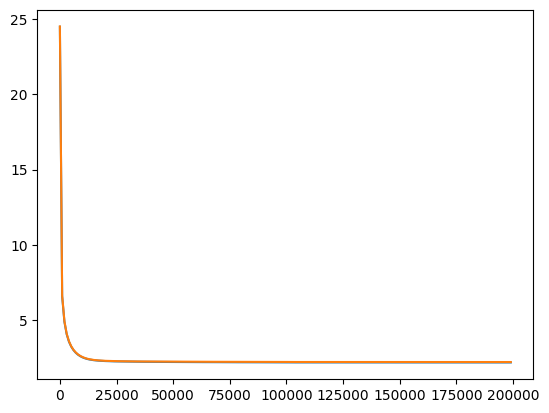

In [ ]:
plt.plot(stepi, loss_tr)
plt.plot(stepi, loss_dev)

In [31]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 3*emb_size) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss 

tensor(2.0860, grad_fn=<NllLossBackward0>)

In [32]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 3*emb_size) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss 

tensor(2.1182, grad_fn=<NllLossBackward0>)

In [ ]:
# after 200k (100k with 0.1 lr, 100k with 0.01)

# emb_size = 20
# hidden_layer_size = 100
# mini_batch_size = 1024
# regularization = 2
#
# tra loss = 2.0860
# dev loss = 2.1182

# emb_size = 20
# hidden_layer_size = 80
# mini_batch_size = 1024
# regularization = 1
#
# tra loss = 2.0908
# dev loss = 2.1340

# emb_size = 20
# hidden_layer_size = 80
# mini_batch_size = 1024
# regularization = 3
#
# tra loss = 2.1240
# dev loss = 2.1536

# emb_size = 20
# hidden_layer_size = 80
# mini_batch_size = 1024
# regularization = 0.0
#
# tra loss = 2.1298
# dev loss = 2.1847

# emb_size = 10
# hidden_layer_size = 200
# mini_batch_size = 32
# regularization = 0.0
#
# tra loss = 2.1315
# dev loss = 2.1854

In [595]:
# End of video Task: beat 2.17 Xdev loss

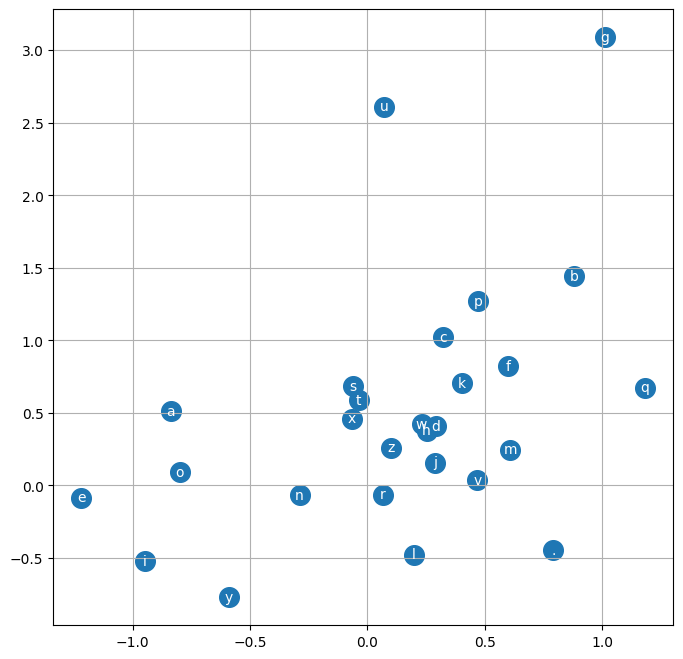

In [356]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')

In [443]:
# sample from the model

g = torch.Generator().manual_seed(2147483647)

for _ in range(20):
    
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        if ix==0:
            break
        out.append(ix)

    print(''.join(itos[i] for i in out))

cezar
mouhamakylez
tyhirvinicolter
makayla
ana
khamiyah
javariana
shiv
amelaya
kaya
darek
hadja
ade
aniamyrn
hasna
malynn
broox
asukh
dra
anwyn
